In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import folium
from folium.plugins import MarkerCluster
from shapely.geometry import Point, LineString, Polygon
import networkx as nx
from shapely.ops import polygonize, linemerge, unary_union

Step 1: Load the street network shapefile

In [3]:
street_network = gpd.read_file('Streets.shp')

Step 2: Check the CRS (Coordinate Reference System)

In [4]:
print("Original CRS:", street_network.crs)

Original CRS: EPSG:4326


Step 3: Convert to a projected CRS if needed (for accurate distance measurements)<br>
Choose an appropriate UTM zone based on your area

In [5]:
projected_crs = "EPSG:3857"  # Web Mercator - adjust as needed
street_network = street_network.to_crs(projected_crs)

Step 4: Explore basic information

In [6]:
print("\nDataset Basic Information:")
print(f"Number of street segments: {len(street_network)}")
print("\nGeometry types:")
print(street_network.geometry.type.value_counts())
print("\nAttribute columns:")
print(street_network.columns)


Dataset Basic Information:
Number of street segments: 494821

Geometry types:
LineString    494821
Name: count, dtype: int64

Attribute columns:
Index(['OBJECTID', 'LINK_ID', 'ST_NAME', 'geometry'], dtype='object')


Step 5: Examine attribute information (helpful for understanding road types)

In [7]:
print("\nSample of attribute data:")
print(street_network.head())


Sample of attribute data:
   OBJECTID      LINK_ID              ST_NAME  \
0         1  590186215.0       Rīga-Stockholm   
1         2  749463153.0  Ventspils-Nynäshamn   
2         3  750303390.0           Rīgas iela   
3         4  750303392.0           Brūža iela   
4         5  750303393.0       Tālavijas iela   

                                            geometry  
0  LINESTRING (2674422.936 7772848.595, 2672650.7...  
1  LINESTRING (2398254.865 7841417.703, 2397160.5...  
2  LINESTRING (2927674.778 7753932.22, 2927611.32...  
3  LINESTRING (3011224.509 7847750.359, 3011218.9...  
4  LINESTRING (3086551.068 7667768.488, 3086525.4...  


Step 6: Extract potential roundabout candidates using geometric properties<br>
There are several approaches:

6.1: Graph-based approach using NetworkX<br>
Convert street segments to a graph

In [8]:
G = nx.Graph()
for idx, row in street_network.iterrows():
    if row.geometry.geom_type == 'LineString':
        # Add each segment with its endpoints as nodes
        start_point = (row.geometry.coords[0][0], row.geometry.coords[0][1])
        end_point = (row.geometry.coords[-1][0], row.geometry.coords[-1][1])
        G.add_edge(start_point, end_point, geometry=row.geometry)

Find circular patterns in the graph<br>
(This is a simplified approach - you'll need to refine this)

In [9]:
cycles = nx.cycle_basis(G)
potential_roundabouts_cycles = [cycle for cycle in cycles if len(cycle) >= 3 and len(cycle) <= 10]

In [10]:
print(f"\nPotential roundabout candidates (cycle-based): {len(potential_roundabouts_cycles)}")


Potential roundabout candidates (cycle-based): 41034


6.2: Geometry-based approach<br>
Detect closed loops from line segments

In [11]:
lines = list(street_network.geometry)
merged_lines = linemerge(lines)
boundaries = unary_union(merged_lines)
potential_polygons = list(polygonize(boundaries))

Filter polygons by size and shape characteristics

In [12]:
min_area = 50  # minimum area in square meters
max_area = 10000  # maximum area in square meters
min_circularity = 0.6  # 1.0 is a perfect circle

In [13]:
roundabout_candidates = []
for polygon in potential_polygons:
    area = polygon.area
    perimeter = polygon.length
    
    # Calculate circularity (how close to a circle)
    circularity = 4 * np.pi * area / (perimeter ** 2) if perimeter > 0 else 0
    
    if (min_area < area < max_area) and circularity > min_circularity:
        roundabout_candidates.append(polygon)

In [14]:
print(f"\nPotential roundabout candidates (geometry-based): {len(roundabout_candidates)}")


Potential roundabout candidates (geometry-based): 8971


Step 7: Create GeoDataFrame from candidates

In [15]:
roundabout_gdf = gpd.GeoDataFrame({'geometry': roundabout_candidates}, crs=projected_crs)
roundabout_gdf['area'] = roundabout_gdf.geometry.area
roundabout_gdf['perimeter'] = roundabout_gdf.geometry.length
roundabout_gdf['circularity'] = 4 * np.pi * roundabout_gdf['area'] / (roundabout_gdf['perimeter'] ** 2)

Step 8: Visualize with Matplotlib

<Axes: >

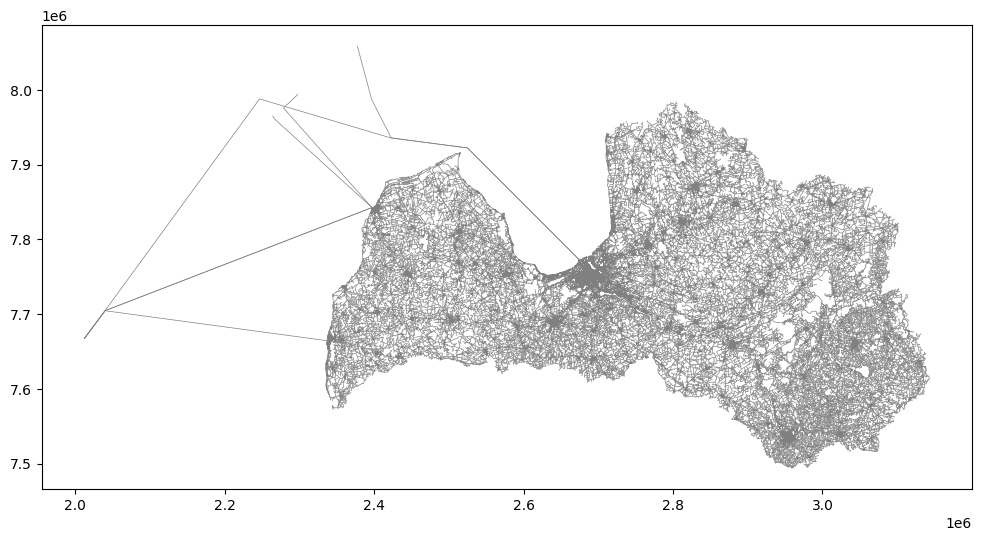

In [16]:
fig, ax = plt.subplots(figsize=(12, 10))
street_network.plot(ax=ax, color='gray', linewidth=0.5)

In [17]:
if not roundabout_gdf.empty:
    roundabout_gdf.plot(ax=ax, color='red', alpha=0.5)

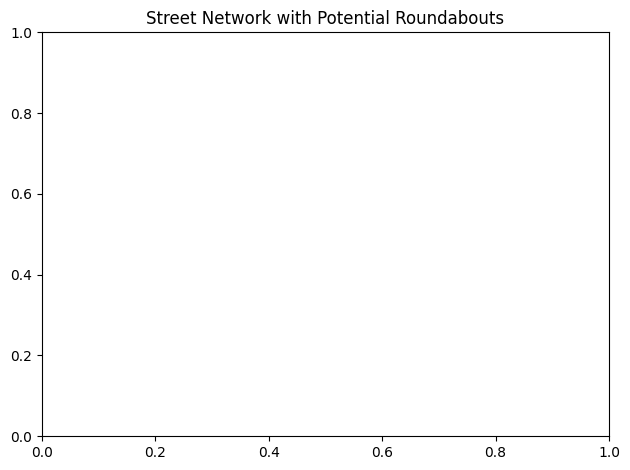

In [18]:
plt.title('Street Network with Potential Roundabouts')
plt.tight_layout()
plt.savefig('potential_roundabouts.png')
plt.show()

Step 9: Visualize with Folium (interactive)<br>
Convert back to WGS84 for web mapping

In [19]:
street_network_wgs84 = street_network.to_crs("EPSG:4326")
roundabout_gdf_wgs84 = roundabout_gdf.to_crs("EPSG:4326") if not roundabout_gdf.empty else None

Create a Folium map

In [20]:
map_center = [street_network_wgs84.geometry.centroid.y.mean(), 
              street_network_wgs84.geometry.centroid.x.mean()]
m = folium.Map(location=map_center, zoom_start=13, tiles='OpenStreetMap')

C:\Users\Jsh Agarwal\AppData\Local\Temp\ipykernel_23176\856213170.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  map_center = [street_network_wgs84.geometry.centroid.y.mean(),
C:\Users\Jsh Agarwal\AppData\Local\Temp\ipykernel_23176\856213170.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  street_network_wgs84.geometry.centroid.x.mean()]


Add street network

In [21]:
for _, row in street_network_wgs84.iterrows():
    if row.geometry.geom_type == 'LineString':
        folium.PolyLine(
            locations=[(lat, lon) for lon, lat in row.geometry.coords],
            color='blue',
            weight=2,
            opacity=0.7
        ).add_to(m)

Add roundabout candidates

In [22]:
if roundabout_gdf_wgs84 is not None and not roundabout_gdf_wgs84.empty:
    for idx, row in roundabout_gdf_wgs84.iterrows():
        # Get polygon boundary as a list of coordinates
        if row.geometry.geom_type in ['Polygon', 'MultiPolygon']:
            # For multipolygons, we just take the first polygon
            if row.geometry.geom_type == 'MultiPolygon':
                polygon = row.geometry.geoms[0]
            else:
                polygon = row.geometry
                
            # Extract exterior coordinates
            coords = [(lat, lon) for lon, lat in polygon.exterior.coords]
            
            # Add polygon to map
            folium.Polygon(
                locations=coords,
                color='red',
                fill=True,
                fill_color='red',
                fill_opacity=0.4,
                popup=f"Area: {row['area']:.1f} mÂ², Circularity: {row['circularity']:.3f}"
            ).add_to(m)

Add layer control

In [23]:
folium.LayerControl().add_to(m)

Save interactive map

In [24]:
m.save('roundabout_detection_interactive.html')
print("\nInteractive map saved as: roundabout_detection_interactive.html")


Interactive map saved as: roundabout_detection_interactive.html


Step 10: Add additional Folium features for better analysis<br>
Create a heatmap of roundabout candidate centroids

In [25]:
if roundabout_gdf_wgs84 is not None and not roundabout_gdf_wgs84.empty:
    # Create a new map for the heatmap
    m_heat = folium.Map(location=map_center, zoom_start=13)
    
    # Get centroids of roundabouts
    roundabout_centroids = roundabout_gdf_wgs84.copy()
    roundabout_centroids['geometry'] = roundabout_centroids.geometry.centroid
    
    # Add centroids as a heat map
    from folium.plugins import HeatMap
    heat_data = [[point.y, point.x] for point in roundabout_centroids.geometry]
    HeatMap(heat_data).add_to(m_heat)
    
    m_heat.save('roundabout_heatmap.html')
    print("Heatmap saved as: roundabout_heatmap.html")

C:\Users\Jsh Agarwal\AppData\Local\Temp\ipykernel_23176\3531513563.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  roundabout_centroids['geometry'] = roundabout_centroids.geometry.centroid


Heatmap saved as: roundabout_heatmap.html


Step 11: Save candidates to GeoJSONL<br>
Convert back to WGS84 for standard GeoJSON if not already

In [26]:
if roundabout_gdf_wgs84 is None and not roundabout_gdf.empty:
    roundabout_gdf_wgs84 = roundabout_gdf.to_crs("EPSG:4326")

Save to GeoJSONL (one feature per line)

In [27]:
if roundabout_gdf_wgs84 is not None and not roundabout_gdf_wgs84.empty:
    with open('roundabout_candidates.geojsonl', 'w') as f:
        for idx, row in roundabout_gdf_wgs84.iterrows():
            geojson_feature = {
                'type': 'Feature',
                'geometry': row.geometry.__geo_interface__,
                'properties': {
                    'area': float(row['area']),
                    'perimeter': float(row['perimeter']),
                    'circularity': float(row['circularity'])
                }
            }
            f.write(f"{pd.Series(geojson_feature).to_json()}\n")
    print("\nGeoJSONL file created: roundabout_candidates.geojsonl")
else:
    print("\nNo roundabout candidates found to save to GeoJSONL.")


GeoJSONL file created: roundabout_candidates.geojsonl
